# Noisy Logistic Map experiment

### Importing libraries

In [1]:
import functools
import pandas as pd
import numpy as np
import ml_confs
import matplotlib.pyplot as plt

from time import perf_counter
from kooplearn.datasets import LogisticMap
from kooplearn.models import KernelDMD
from kooplearn.data import traj_to_contexts
from kooplearn._src.utils import topk
from kooplearn._src.metrics import directed_hausdorff_distance
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from scipy import stats

### Defining some functions

In [2]:
configs_dict = {
    'N': 20,
    'num_train': 20000,
    'num_val': 5000,
    'num_test': 10000,
    'rank': 3,
}

configs = ml_confs.from_dict(configs_dict, register_jax_pytree=False)

def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = perf_counter()
        value = func(*args, **kwargs)
        toc = perf_counter()
        elapsed_time = toc - tic
        return value, elapsed_time

    return wrapper_timer

plt.rcParams.update({
    # "text.usetex": matplotlib.checkdep_usetex(True),
    # "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amssymb}',
    # "mathtext.fontset": "dejavuserif",
    # "font.family": "serif",
    # "font.serif": ["Times"],
    "font.size": 8,
    "axes.titlesize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
})
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a,axis=1), stats.sem(a, axis=1)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def R4_repeated_runs(n_rep):
    risks_train = []
    risks_test = []
    timings = []
    eigs = []
    Hdist = []
    svals = []
    model = KernelDMD(kernel = kernel, rank = configs.rank, tikhonov_reg = reg, svd_solver='randomized', n_oversamples=20, iterated_power=1)
    for r in tqdm(np.arange(n_rep),total=n_rep,desc='R4 repetitions'):
        model.rng_seed = r
        timed_fit = timer(model.fit)
        model, fit_time = timed_fit(train_ctx, verbose=False)
        timings.append(fit_time)
        risks_train.append(model.risk())
        risks_test.append(model.risk(test_ctx))
        svals.append(model.svals())
        all_eigs = model.eig()
        top_eigs = topk(np.abs(all_eigs), 3)
        eigs.append(all_eigs[top_eigs.indices])
        Hdist.append(directed_hausdorff_distance(eigs[-1], ref_eigs))
    return risks_train, risks_test, eigs, svals, Hdist, timings

def R3_repeated_runs(n_rep):
    timings = []
    model = KernelDMD(kernel = kernel, rank = configs.rank, tikhonov_reg = reg, svd_solver='arnoldi')
    for r in tqdm(np.arange(n_rep),total=n_rep,desc='R3 repetitions'):
        model.rng_seed = r
        timed_fit = timer(model.fit)
        model, fit_time = timed_fit(train_ctx, verbose=False)
        timings.append(fit_time)
    return timings

def train_and_eval(ls, reg, kernel, svd_solver, n_oversamples=20, rank=configs.rank, rng_seed=0):
    kernel = kernel(length_scale=ls)
    if svd_solver == 'randomized':
        model = KernelDMD(kernel=kernel, rank=rank, tikhonov_reg=reg, svd_solver=svd_solver, n_oversamples=n_oversamples,
                          rng_seed=rng_seed)
    else:
        model = KernelDMD(kernel=kernel, rank=rank, tikhonov_reg=reg, svd_solver=svd_solver,
                          n_oversamples=n_oversamples,
                          rng_seed=rng_seed)
    timed_fit = timer(model.fit)
    model, fit_time = timed_fit(train_ctx, verbose=False)
    val_risk = model.risk(val_ctx)
    return model, val_risk, fit_time

def grid_search(hp_grid, svd_solver):
    best_risk = np.inf
    best_vals = None
    best_model = None

    timings = []
    risks = []
    kernel = RBF

    for hp in tqdm(hp_grid, total=len(hp_grid), desc='HP tuning'):
        model, val_risk, fit_time = train_and_eval(hp['ls'], hp['reg'], kernel, svd_solver, rng_seed=42)
        timings.append(fit_time)
        risks.append(val_risk)
        if val_risk < best_risk:
            best_risk = val_risk
            best_vals = hp
            best_model = model

    return best_risk, best_vals, best_model, timings

### Dataset generation

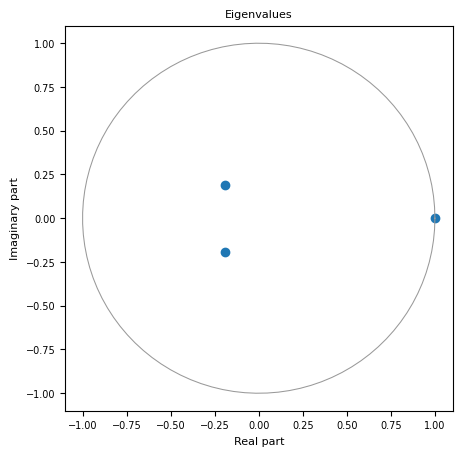

In [3]:
logistic = LogisticMap(N=configs.N, rng_seed=42)
# Data pipeline
sample_traj = logistic.sample(
    0.5, configs.num_train + configs.num_val + configs.num_test
)

dataset = {
    "train": sample_traj[: configs.num_train],
    "validation": sample_traj[configs.num_train : configs.num_train + configs.num_val],
    "test": sample_traj[configs.num_train + configs.num_val :],
}

ref_eigs = logistic.eig()
top_eigs = topk(np.abs(ref_eigs), 3)
ref_eigs = ref_eigs[top_eigs.indices]

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(ref_eigs.real, ref_eigs.imag)
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), linestyle='-', color='#999', lw=0.75)
ax.set_xlabel('Real part')
ax.set_ylabel('Imaginary part')
ax.set_title('Eigenvalues')
plt.show()

### Running the experiment

In [5]:
n_training_samples = np.concatenate([np.arange(200,1000,100),np.arange(1000,10001,1000),])

test_ctx = traj_to_contexts(dataset['test'])
val_ctx = traj_to_contexts(dataset['validation'])

R3_risk_test = []
R4_risk_test = []
R3_risk_train = []
R4_risk_train = []
R3_time = []
R4_time = []
R3_Hdist = []
R4_Hdist = []
R3_eigs = []
R3_svals = []
R4_eigs = []
R4_svals = []

for n in n_training_samples:
    print('Training Sample size: ', n)
    train_traj = dataset['train'][:n]
    train_ctx = traj_to_contexts(train_traj)

    ls_grid = [1]
    reg_grid = [1e-7]
    hp_grid = ParameterGrid({'ls': ls_grid, 'reg': reg_grid})

    if len(hp_grid) >1:
        best_risk, best_vals, best_model, _ = grid_search(hp_grid, 'arnoldi')
        print(best_risk, best_vals)
        ls = best_vals['ls']
        reg = best_vals['reg']
    else:
        ls = ls_grid[0]
        reg = reg_grid[0]

    kernel = RBF(length_scale=ls)
    R3 = KernelDMD(kernel=kernel, rank=configs.rank, tikhonov_reg=reg, svd_solver='arnoldi', rng_seed=0)

    timed_fit = timer(R3.fit)
    R3, fit_time = timed_fit(train_ctx, verbose=False)
    R3_risk_train.append(R3.risk())
    R3_risk_test.append(R3.risk(test_ctx))
    eigs = R3.eig()
    top_eigs = topk(np.abs(eigs), 3)
    R3_eigs.append(eigs[top_eigs.indices])
    R3_Hdist.append(directed_hausdorff_distance(R3_eigs[-1], ref_eigs))
    R3_svals.append(R3.svals())
    R3_time.append(fit_time)

    risks_train, risks_test, eigs, svals, Hdists, timings = R4_repeated_runs(100)
    R4_risk_train.append(risks_train)
    R4_risk_test.append(risks_test)
    R4_eigs.append(eigs)
    R4_Hdist.append(Hdists)
    R4_time.append(timings)
    R4_svals.append(svals)

dict = {
    'n_training_samples': n_training_samples,
    'R3_risk_train': R3_risk_train,
    'R3_risk_test': R3_risk_test,
    'R4_risk_train': R4_risk_train,
    'R4_risk_test': R4_risk_test,
    'R3_time': R3_time,
    'R4_time': R4_time,
    'R3_Hdist': R3_Hdist,
    'R4_Hdist': R4_Hdist,
    'R3_eigs': R3_eigs,
    'R3_svals': R3_svals,
    'R4_eigs': R4_eigs,
    'R4_svals': R4_svals
}

results = pd.DataFrame(dict)
results.to_pickle('noisy_logistic_map.pkl')

Training Sample size:  200


R4 repetitions:   0%|          | 0/100 [00:00<?, ?it/s]/home/gturri/miniconda3/envs/torch/lib/python3.10/site-packages/kooplearn/_src/operator_regression/dual.py:282: RuntimeWarning: invalid value encountered in sqrt
  normalization_csts = (np.sum(vectors.conj() * (F_0 @ vectors), axis=0).real) ** 0.5
R4 repetitions: 100%|██████████| 100/100 [03:34<00:00,  2.15s/it]


Training Sample size:  300


R4 repetitions: 100%|██████████| 100/100 [03:36<00:00,  2.16s/it]


Training Sample size:  400


R4 repetitions: 100%|██████████| 100/100 [03:38<00:00,  2.19s/it]


Training Sample size:  500


R4 repetitions: 100%|██████████| 100/100 [03:42<00:00,  2.22s/it]


Training Sample size:  600


R4 repetitions: 100%|██████████| 100/100 [03:44<00:00,  2.25s/it]


Training Sample size:  700


R4 repetitions: 100%|██████████| 100/100 [03:47<00:00,  2.28s/it]


Training Sample size:  800


R4 repetitions: 100%|██████████| 100/100 [03:50<00:00,  2.31s/it]


Training Sample size:  900


R4 repetitions: 100%|██████████| 100/100 [03:53<00:00,  2.34s/it]


Training Sample size:  1000


R4 repetitions: 100%|██████████| 100/100 [03:56<00:00,  2.37s/it]


Training Sample size:  2000


R4 repetitions: 100%|██████████| 100/100 [04:35<00:00,  2.75s/it]


Training Sample size:  3000


R4 repetitions: 100%|██████████| 100/100 [05:46<00:00,  3.46s/it]


Training Sample size:  4000


R4 repetitions: 100%|██████████| 100/100 [07:09<00:00,  4.30s/it]


Training Sample size:  5000


R4 repetitions: 100%|██████████| 100/100 [08:48<00:00,  5.28s/it]


Training Sample size:  6000


R4 repetitions: 100%|██████████| 100/100 [10:50<00:00,  6.50s/it]


Training Sample size:  7000


R4 repetitions: 100%|██████████| 100/100 [13:13<00:00,  7.94s/it]


Training Sample size:  8000


R4 repetitions: 100%|██████████| 100/100 [16:07<00:00,  9.68s/it]


Training Sample size:  9000


R4 repetitions: 100%|██████████| 100/100 [19:25<00:00, 11.66s/it]


Training Sample size:  10000


R4 repetitions: 100%|██████████| 100/100 [23:11<00:00, 13.92s/it]


### Plotting Figure 4

In [6]:
from pseudopy import NonnormalMeshgrid
import scipy.integrate
N = logistic.N
def alphas_mat_el(i: int, j: int):
    def pairing(x):
        return logistic.noise_feature_composed_map(
            x, i
        ) * logistic.noise_feature_composed_map(x, j)

    return scipy.integrate.quad(pairing, 0, 1)[0]

def betas_mat_el(i: int, j: int):
    def pairing(x):
        return logistic.noise_feature(x, i) * logistic.noise_feature(x, j)

    return scipy.integrate.quad(pairing, 0, 1)[0]

def koopman_el(i: int, j: int):
    def pairing(x):
        return logistic.noise_feature(x, i) * logistic.noise_feature_composed_map(x, j)

    return scipy.integrate.quad(pairing, 0, 1)[0]

def fmt_fn(level):
    level_exp = str(int(np.round(np.log10(level), 0)))
    return f"$10^{{{level_exp}}}$"

K = np.array([[koopman_el(i, j) for j in range(N + 1)] for i in range(N + 1)])
psspectra = NonnormalMeshgrid(K, real_n = 200, imag_n = 200)

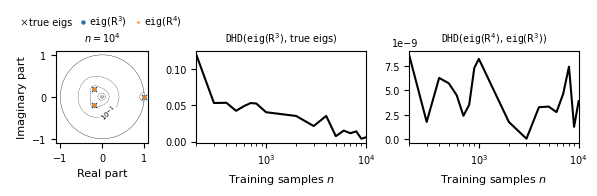

In [7]:
results = pd.read_pickle('noisy_logistic_map.pkl')
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

n = results['n_training_samples']

R3_eigs = np.array(results.R3_eigs)
R4_eigs = np.array(results.R4_eigs)

fig_width = 6 #Inches
fig_height = 1.8 #Inches

fig, axes = plt.subplots(ncols=3, figsize=(fig_width, fig_height),width_ratios=[0.6,1,1])

ax = axes[0]

levels = [10 ** i for i in [-5, -4, -3, -2]]
contours = ax.contour(psspectra.Real, psspectra.Imag, psspectra.Vals, levels=levels, colors='k', linestyles='dashed',
                      linewidths=0.25, zorder=-1)
levels = [10 ** -1]
contours = ax.contour(psspectra.Real, psspectra.Imag, psspectra.Vals, levels=levels, colors='k', linestyles='dashed',
                      linewidths=0.25, zorder=-1)
ax.clabel(contours, inline=1, inline_spacing=5, fmt=fmt_fn, fontsize=5, zorder=-1)

theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), linestyle='-', color='black', lw=0.25, zorder=-1)

ax.scatter(ref_eigs.real, ref_eigs.imag, marker='x', color='black', label='true eigs',lw=.5,s=15, zorder=1)
ax.scatter(R3_eigs[-1].real, R3_eigs[-1].imag, color=cycle[0], label='$\mathtt{eig}$(R$^3$)', alpha=1, lw=0, s=10, zorder=1)
ax.scatter([], [], color=cycle[1], s=3, lw=0,label='$\mathtt{eig}$(R$^4$)')
for el in R4_eigs[-1]:
    ax.scatter(el.real, el.imag, color=cycle[1], s=3, lw=0, zorder=1)

ax.set_xlabel('Real part')
ax.set_ylabel('Imaginary part')
ax.set_title('$n=10^4$', fontsize=7)
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_box_aspect(1)
ax.legend(bbox_to_anchor=(-0.5, 1.3, 1.9, 0.15), loc='upper center', borderaxespad=0,
          mode='expand', ncol=3, frameon=False, handletextpad=-0.4)

ax = axes[1]
h_dist_R3_ref = np.zeros(len(R3_eigs))
for i, el in enumerate(R3_eigs):
    h_dist_R3_ref[i] = directed_hausdorff_distance(el, ref_eigs)

ax.plot(n, h_dist_R3_ref, 'k')
ax.set_xlabel('Training samples $n$')
ax.set_title("$\mathtt{DHD}$($\mathtt{eig}$(R$^3$), true eigs)", fontsize=7)
ax.set_xscale('log')
ax.set_xmargin(0)

ax = axes[2]
h_dist_R3_R4 = np.zeros((len(R4_eigs),len(R4_eigs[0])))
for i in range(len(R4_eigs)):
    for j in range(len(R4_eigs[0])):
        h_dist_R3_R4[i,j] = directed_hausdorff_distance(R4_eigs[i][j], R3_eigs[i])

m, risk_min, risk_max = mean_confidence_interval(h_dist_R3_R4)

ax.plot(n, m, 'k')
ax.fill_between(n, risk_min, risk_max, alpha=0.3, color='k', linewidth=0)
ax.set_xlabel('Training samples $n$')
ax.set_title("$\mathtt{DHD}$($\mathtt{eig}$(R$^4$), $\mathtt{eig}$(R$^3$))", fontsize=7)
ax.set_xscale('log')
ax.yaxis.offsetText.set_position([-0.1,1])
ax.set_xmargin(0)

plt.tight_layout()
plt.show()
fig.savefig("noisy_logistic_map.pdf",  bbox_inches='tight')